In [1]:
import numpy as np
import sys
from pathlib import Path

sys.path.append('../code/')

from mlalgos import Sequential,GAN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `GAN` (Generative Adversarial Network)

## Derivative test

#### Function definition

In [3]:
def func(x):
    return np.exp(-0.5*x**2)

def der(x):
    return -x*np.exp(-0.5*x**2)

X = ml.rv(np.linspace(-1.5,2,60))
Y = func(X)
dYdX = der(X)

#### Network setup and training

In [4]:
Train = False

Path('gan/ddx_test').mkdir(parents=True,exist_ok=True)
File_Stem = 'gan/ddx_test'+'/ddx_test'
print('File_Stem:',File_Stem)

start_time = time()
L = 5
params = {'data_dim':X.shape[0],'L':L,
          'n_layer':[300]*(L-1)+[Y.shape[0]],
          'atypes':['tanh']*(L-1)+['lin'],
          'loss_type':'square','file_stem':File_Stem}
params_train = {'max_epoch':3000,'lrate':3e-5,'mb_count':6,'val_frac':0.2,'check_after':300}

net = Sequential(params)

if Train:
    net.train(X,Y,params_train)
    net.save()
else:
    net.load()

print('No. of params optimized = {0:d}'.format(net.calc_N_freeparams()))

ut.time_this(start_time)

File_Stem: gan/ddx_test/ddx_test
... setting up 5 layer feed-forward neural network
... ... expecting data dim = 1, target dim = 1
... ... using hidden layers of sizes [300,300,300,300]
... ... ... and activations [tanh,tanh,tanh,tanh]
... ... using last activation layer 'lin'
... ... ... with threshold (None means default): None
... ... using loss function 'square'
... ... not using any regularization
... ... not using any weight decay
No. of params optimized = 271801
0 min 0.03 seconds



#### Plot

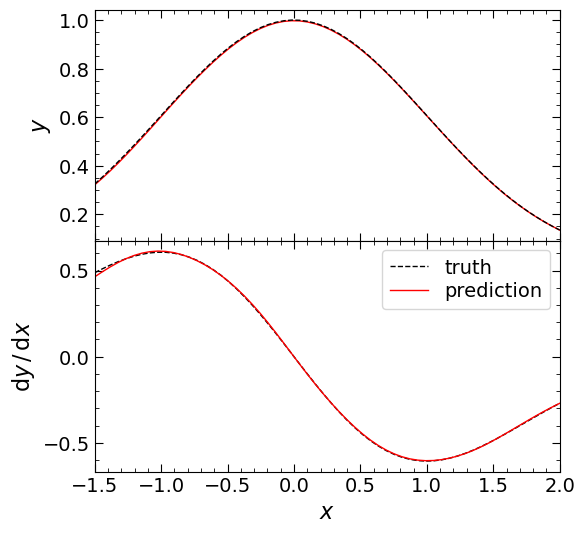

In [5]:
plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1,height_ratios=[1,1],hspace=0)
ax1 = plt.subplot(gs[0])
ax1.set_xlim(X.min(),X.max())
ax1.set_xticklabels('')
ax1.set_ylabel('$y$')
ax1.plot(X[0],net.predict(X)[0],'r-',lw=1,label='prediction')
ax1.plot(X[0],Y[0],'k--',lw=1,label='truth')
ax1.minorticks_on()

ax2 = plt.subplot(gs[1])
ax2.set_xlim(X.min(),X.max())
ax2.set_xlabel('$x$')
ax2.set_ylabel('${\\rm d}y\\,/\\,{\\rm d}x$')
ax2.plot(X[0],dYdX[0],'k--',lw=1,label='truth')
ax2.plot(X[0],net.gradient(X)[0,0],'r-',lw=1,label='prediction')
ax2.legend(loc='upper right')
ax2.minorticks_on()

plt.show()

## GAN Test

#### Create input/target sample

In [6]:
Seed = 1991
rng = np.random.RandomState(Seed)

n_samp = 5000 # number of training samples

XDict = {'g-mean':{'n0':1,'mu':2.0,'sig':1.0},
         'g-std':{'n0':1,'mu':0.0,'sig':3.0},
         'g-meanstd':{'n0':1,'mu':5.0,'sig':3.0}}

TType = 'g-meanstd'
n0 = XDict[TType]['n0'] # input dimension
X = XDict[TType]['mu'] + XDict[TType]['sig']*rng.randn(n0,n_samp)

#### Setup and train GAN
see also [this url](https://github.com/soumith/ganhacks)

In [7]:
Train = True

n0ran = 1 # random dimension

GAN_Type = 'minimax' # 'minimax','modified' [,'wasserstein': not trainable]
LReLU_Slope = 3e-2       # 3e-2 # only relevant if (AType_G == 'lrelu') | (AType_D == 'lrelu'):
Label_Smoothing = 0.3    # 0.3 # None or float in (0,0.5)
Flip_Freq = None         # None? # None or float in (0,1)
Cond_NoNoise = (np.fabs(np.mean(X))/np.std(X) <= 1.0)
Noise = None if Cond_NoNoise else np.std(X) # not clear # None or positive float
Standardize = True       # (GAN_Type != 'wasserstein') 
LRate = 1e-3             # 1e-3 for non-wasserstein
if Standardize:
    Use_Tanh = True
    Use_Sigm = False
    Last_AType_G = 'tanh' if Use_Tanh else 'lin'
else:
    Use_Tanh = False
    Use_Sigm = False
    Last_AType_G = 'lin'

# ME_Dict = {'g-mean':8000,'g-std':18000,'g-meanstd':8000}
ME_Dict = {'g-mean':{'minimax':3000,'modified':6000},
           'g-std':{'minimax':4000,'modified':6000},
           'g-meanstd':{'minimax':4000,'modified':1000}}
CA_Dict = {'g-mean':{'minimax':1000,'modified':1000},
           'g-std':{'minimax':1500,'modified':1500},
           'g-meanstd':{'minimax':1500,'modified':100}}
SC_Dict = {'g-mean':{'minimax':'fid','modified':'fid'},
           'g-std':{'minimax':'fid','modified':'fid'},
           'g-meanstd':{'minimax':'klg','modified':'klg'}}

# Reg_Fun = 'drop' if TType in ['g-meanstd'] else 'none'
# P_Drop = 0.5 if TType in ['g-meanstd'] else 0.0

LG = 4            # 4
NNodes_G = 10     # 10
AType_G = 'relu'  # prefer 'relu'
Wt_Decay_G = 0.0  # 0.0 is fine for all
Decay_Norm_G = 2  # 2

LD = 8            # 8
NNodes_D = 10     # 10
AType_D = 'lrelu' # always 'lrelu'
Wt_Decay_D = 0.0  # 0.0 is fine for non-Wasserstein
Decay_Norm_D = 2  # 2
Last_AType_D = 'sigm' # if GAN_Type != 'wasserstein' else 'tanh'

Path('gan/'+TType).mkdir(parents=True,exist_ok=True)
File_Stem = 'gan/'+TType+'/test_{0:d}d'.format(n0)+'_'+GAN_Type
print('File_Stem:',File_Stem)

start_time = time()
params_setup = {'data_dim':n0,'rand_dim':n0ran,'file_stem':File_Stem,'seed':None,#1991,
                'gan_type':GAN_Type,'use_tanh':Use_Tanh,'use_sigm':Use_Sigm,'standardize':Standardize,'label_smoothing':Label_Smoothing,
                'flip_freq':Flip_Freq,'lrelu_slope':LReLU_Slope,'noise':Noise,
                'Lg':LG,'n_layer_g':[NNodes_G]*(LG-1)+[n0],'atypes_g':[AType_G]*(LG-1)+[Last_AType_G],
                'wt_decay_g':Wt_Decay_G,'decay_norm_g':Decay_Norm_G,#'reg_fun':Reg_Fun,'p_drop':P_Drop,
                'Ld':LD,'n_layer_d':[NNodes_D]*(LD-1)+[1],'atypes_d':[AType_D]*(LD-1)+[Last_AType_D],
                'wt_decay_d':Wt_Decay_D,'decay_norm_d':Decay_Norm_D}

gan = GAN(params=params_setup)
if Train:
    Max_Epoch =  ME_Dict[TType][GAN_Type]
    params_train = {'max_epoch_d':1,# if GAN_Type != 'wasserstein' else 2,
                    'lrate_d':LRate,
                    'max_epoch_g':Max_Epoch,'lrate_g':LRate,
                    'mb_size':None,
                    'check_after':CA_Dict[TType][GAN_Type],
                    'stop_criterion':CA_Dict[TType][GAN_Type]}
    gan.train(X,params=params_train)
    gan.save()
else:
    gan.load()
    params_setup = gan.params
    print(params_setup)

print('No. of params optimized = {0:d}'.format(gan.calc_N_freeparams()))

Z = gan.noise_prior(n0ran,n_samp)
X_Gen = gan.generate(Z)
ut.time_this(start_time)

File_Stem: gan/g-meanstd/test_1d_minimax
Setting up GAN with 8-layer discriminator and 4-layer generator
... ** assumes standard Gaussian noise prior at present **
... GAN type: minimax
... ... expecting data dim = 1, random dim = 1, output dim = 1
... ...  Gen using hidden layers of sizes [10,10,10,1]
... ... ... and activations [relu,relu,relu,tanh]
... ... Disc using hidden layers of sizes [10,10,10,10,10,10,10,1]
... ... ... and activations [lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,sigm]
... ... leaky ReLU will use slope = 3.00e-02
... ... using NLL loss function
... ... using standardization
... ... using label smoothing = 0.300
... ... not using any regularization
... ... not using any weight decay in Gen
... ... not using any weight decay in Disc
... ... input labels to Disc will not be flipped
... ... noise of width 3.00e+00 with 1/t annealing will be added to Disc and Gen inputs while training
... setup complete
... training
... no mb_size specified. Setting to n_samp // 2.
[

#### Plot

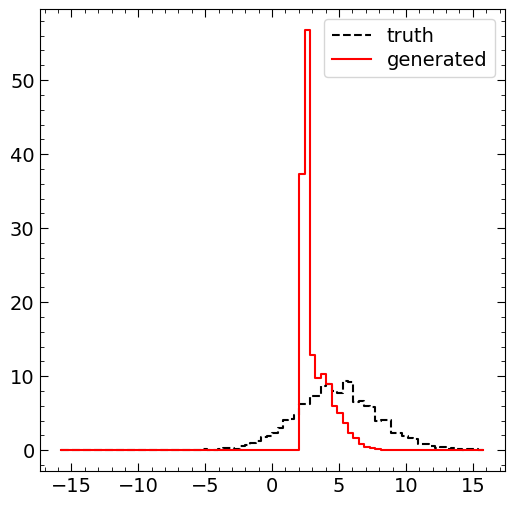

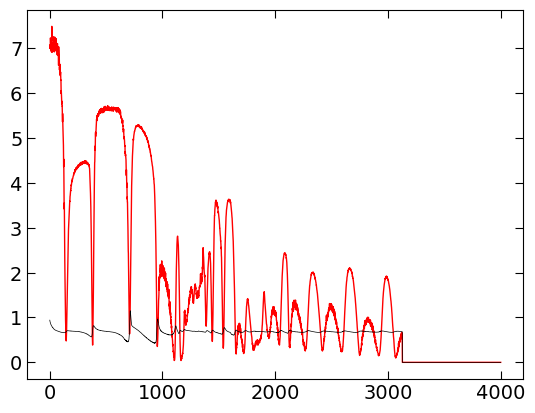

Stats:
... mean: data = 5.037e+00; gen = 3.348e+00
...  std: data = 3.001e+00; gen = 1.052e+00


In [8]:
xbin = np.linspace(-16,16,80)
xmid = 0.5*(xbin[1:]+xbin[:-1])
dx = xmid[1] - xmid[0]
hist_target,dummy = np.histogram(X[0],bins=xbin) 
hist_target = hist_target/dx/xmid.size

hist_gen,dummy = np.histogram(X_Gen[0],bins=xbin) 
hist_gen = hist_gen/dx/xmid.size

plt.figure(figsize=(6,6))
plt.plot(xmid,hist_target,'k--',drawstyle='steps',label='truth')
plt.plot(xmid,hist_gen,'r-',drawstyle='steps',label='generated')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.show()

if Train:
    plt.plot(gan.epochs,gan.gen_loss,'r-',lw=1)
    plt.plot(gan.epochs_all/params_train['max_epoch_d'],gan.disc_loss,'k-',lw=0.5)
    plt.show()

print('Stats:')
print('... mean: data = {0:.3e}; gen = {1:.3e}'.format(X.mean(),X_Gen.mean()))
print('...  std: data = {0:.3e}; gen = {1:.3e}'.format(X.std(),X_Gen.std()))

In [9]:
X[:,:5],gan.discriminate(X[:,:5]),gan.discriminate(X_Gen[:,:5]),X_Gen[0,:5],Z[0,:5]

(array([[2.16970464, 5.147866  , 1.13336164, 4.61240611, 7.20813224]]),
 array([[0.50065761, 0.21232769, 0.57405645, 0.25596659, 0.0916682 ]]),
 array([[0.44758207, 0.44930053, 0.44057622, 0.19130671, 0.45236577]]),
 array([2.67397882, 2.65223632, 2.76278909, 5.43192719, 2.61349139]),
 array([ 0.20700202,  0.31704694,  1.53363226, -1.5134467 ,  0.60635975]))